In [14]:
import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 14.0

# Introducing modelling and analysis through May '77

We will be introducing you to a bit of modelling and subsequent data analysis in Python, by reproducing some of the results found in the review article by May (Nature v. 269, p. 471-477, 1977, [doi:10.1038/269471a0](https://www.nature.com/articles/269471a0)). This paper describes bifurcation in population models of the spruce budworm using this differential equation:

$$\frac{{\rm d} N}{{\rm d} t} = r N \left(1 - \frac{N}{K}\right) - \frac{cN^2}{H^2 + N^2}.$$

$$\frac{{\rm d} N}{{\rm d} t} = r N \left(1 - \frac{N}{K}\right) - \frac{cN^2}{H^2 + N^2} + \sigma {\rm d}W_t.$$

We will integrate this equation using Euler's method and add a stochastic term to this model (the hand that rocks the cradle), in order to find equilibria and/or bifurcation points. This will generate some time-series that we can analyse subsequently.

$$N_{i+1} = N_{i} + \Delta{}t \left(r N_{i} \left(1 - \frac{N_{i}}{K}\right) - \frac{c N_{i}^2}{H^2 + N_{i}^2}\right) + \sigma\ \Delta{}W_i$$

Let us first write down  the differential equation in a form that Python understands:

In [15]:
def dNdt(N, t, c, r, K, H):
    return r*N * (1 - N/K) - c * N**2 / (H**2 + N**2)

Later on, we will be integrating this equation while varying the parameter $c$. For the moment let us see how this function behaves for different values of $c$. We may give the values of the other arguments in the form of a dictionary. We chose some values that should be reasonable.

In [16]:
settings = {
    'r': 1.0,
    'K': 10,
    'c': 2.0,
    'H': 1.0
}

> ### Note: keyword arguments and dictionary unpacking
> We will apply these values to the function ``dNdT(...)`` by using keyword-argument expansion.
> 
> ```python
> dNdt(N, **settings)
> ```
>
> with the current value of ``settings`` is like saying
>
> ```python
> dNdt(N, c=2.0, r=1.0, K=10, H=1.0)
> ```

## Plotting
We'll create some plots to study the behaviour of this model.

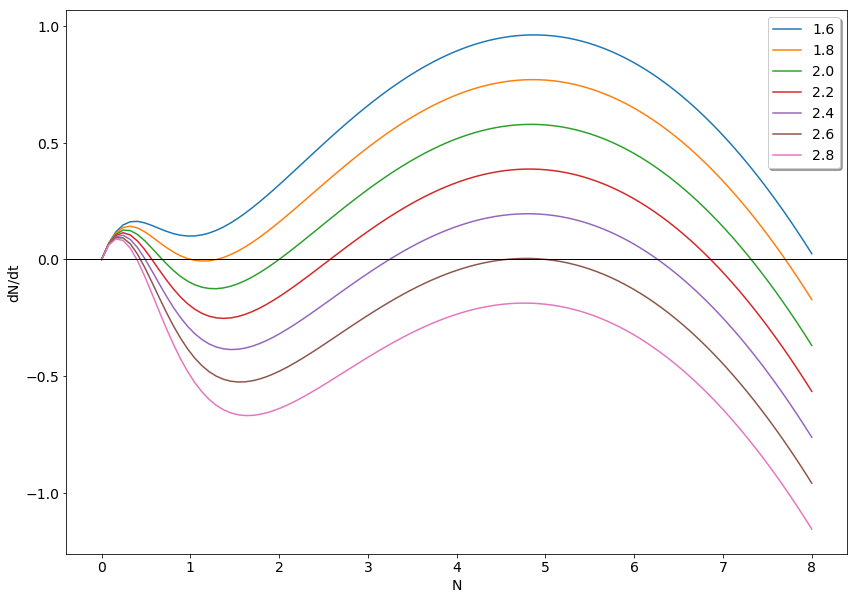

In [17]:
# Generate an array of 100 numbers in the range of [0.0-8.0] (inclusive)
N = np.linspace(0, 8, 100)

fig = plt.subplot(111)  # obtain a figure object

for c in np.linspace(1.6, 2.8, 7):  # Loop over several values for `c`
    settings.update(c=c)            # change only the value of 'c' in `settings`
    dN = dNdt(N, 0, **settings)     # apply our function for dN/dt
    fig.plot(N, dN, label='{:.03}'.format(c))  # plot

fig.axhline(0.0, c='k', linewidth=1)        # add a line on y == 0.0
fig.legend(loc='upper right', shadow=True)  # add a legend
fig.set_xlabel('N')                         # set labels
fig.set_ylabel('dN/dt')

# save as PDF when you're happy!
# plt.savefig('model-diff.pdf')

plt.show()

> ### Note: vectorized functions
> In making these plots, our function `dNdt` was applied to a whole array of values. First we defined a series of values for `N`
> ```python
> N = np.linspace(0, 8, 100)
> ```
> Then, we applied `dNdt`
> ```python
> dN = dNdt(N, 0, **settings)
> ```
> We could do this because all the things we do in the body of `dNdt` are valid on both plain numbers and `numpy` arrays. We will call functions that work on numbers as well as arrays *vectorized functions*.
>
> Whenever possible, when doing numerical calculations in Python, make sure to use vectorized functions. The alternative is to write for-loops, which is much much *slower*. Later on we will see an example of a function that is less easy to vectorize.

Interesting things happen when derivatives vanish. Where lines cross the x-axis upward, we find unstable equilibria, and similarly, downward crossing gives a stable equilibrium. This plot tells us to expect interesting things (i.e. bifurcation) near $c=1.8$ and $c=2.6$. For those values the vanishing first derivative coinside with vanishing second derivative.

We can tell more about the situation at these special points by making a contour plot of ${\rm d}N/{\rm d}t$ with varying $N$ and $c$. To make matters easier we can get an analytic expression for the roots
$$\frac{dN}{dt} = 0,$$
which is solved by
$$N = 0$$
and
$$c = r\left(\frac{H^2}{N} - \frac{H^2}{K} + N - \frac{N^2}{K}\right).$$
This expression implicitely tells us what the equilibrium values for $N$ are, given $c$.
To find the tipping point values for $c$, we should see where the derivatives vanish, giving
$$\frac{{\rm d} c}{{\rm d} N} = r\left(-\frac{2}{K} N^3 + N^2 - H^2\right) = 0.$$
This cubic polynomial can be solved using Cardano's formula ([for reference, see Wikipedia](https://en.wikipedia.org/wiki/Cubic_function#General_solution_to_the_cubic_equation_with_real_coefficients)).

In [44]:
def cubic_roots(a, b, c, d):
    """Compute the roots of the cubic polynomial :math:`ax^3 + bx^2 + cx + d`.
    
    :param a: cubic coefficient
    :param b: quadratic coefficient
    :param c: linear coefficient
    :param d: constant
    :return: list of three complex roots
    
    This function does not check if the found roots are real or complex.
    """
    delta_0 = b**2 - 3*a*c
    delta_1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    C = ((delta_1 + np.sqrt(delta_1**2 - 4*delta_0**3 + 0j)) / 2)**(1/3)
    zeta = -1/2 + 1j/2 * np.sqrt(3)
    return [-1/(3*a) * (b + zeta**k * C + delta_0 / (zeta**k * C))
            for k in [0, 1, 2]]

> #### Note: Documentation
> The first expression in the definition of `cubic_roots` is a long string containing the documentation of the function: the *docstring*. All parameters to the function, and its return value are touched upon. You can look up the docstring of a function or object by typing `help(<function name>)`.
>
> For the curious: the particular format of this docstring is not set in stone, but in this case we use [Sphinx Restructured Text](http://www.sphinx-doc.org/en/stable/rest.html). Sphinx enables us to create online documentation for libraries.

In [43]:
help(cubic_roots)

Help on function cubic_roots in module __main__:

cubic_roots(a, b, c, d)
    Compute the roots of the cubic polynomial $ax^3 + bx^2 + cx + d$.
    
    :param a: cubic coefficient
    :param b: quadratic coefficient
    :param c: linear coefficient
    :param d: constant
    :return: list of three complex roots
    
    This function does not check if the found roots are real or complex.



> #### Note: complex numbers
> Note that Cardano's formula involves complex numbers. The Python syntax for imaginary numbers is the floating point value with a `j` suffix.
>
> ```python
> >>> x = 1 + 2j
> >>> x.real
> 1.0
> >>> x.imag
> 2.0
> >>> print(x)
> (1+2j)
```
>
> Computing square roots using the power notation ``a**b`` automatically results in complex values when the need arises:
> 
> ```python
> >>> from numpy import sqrt, cbrt
> >>> sqrt(-1)
> __main__:1: RuntimeWarning: invalid value encountered in sqrt
> nan
> >>> (-1)**(1/2)
> (6.123233995736766e-17+1j)
> >>> sqrt(-1+0j)
> 1j
> ```

In [19]:
r = settings['r']
H = settings['H']
K = settings['K']

def cn(N, r, H, K):
    return r*(H**2/N + N - H**2/K - N**2/K)

def extrema_cn(r, H, K):
    return cubic_roots(-2/K, 1, 0, -H**2)

N_tipping = np.sort(np.array(
    [e.real for e in 
     extrema_cn(settings['r'], settings['H'], settings['K'])]))

print("tipping N:", N_tipping)
print("tipping c:", cn(N_tipping, r, H, K))

tipping N: [-0.919089   1.1378052  4.7812838]
tipping c: [-2.19159537  1.7872302   2.60436517]


The negative values are not *real* in the physical sense of the model, so we'll ignore them. The values we find for $c = 1.787$ and $c = 2.604$ do match our expectations. 

> ### Note: list comprehensions
> This last bit of code contains a list comprehension. In general a list comprehension looks like:
> ```python
> result = [<expression> for <variable> in <collection>]
> ```
> You could (but shouldn't!) do the same doing:
> ```python
> result = []
> for <variable> in <collection>:
>     result.append(<expression>)
> ```
> In general the latter will result in slower code, and it is considered bad style. If the code in `<expression>` becomes too involved for a one-line expression, it is better to put it in a separate function.
>
> Python has similar forms to construct dictionaries and sets.

We're now ready to combine all this information into a diagram, similar to Fig. 6 in May77. This plotting example is a bit more involved. Making nice plots can involve quite a bit of tweaking!

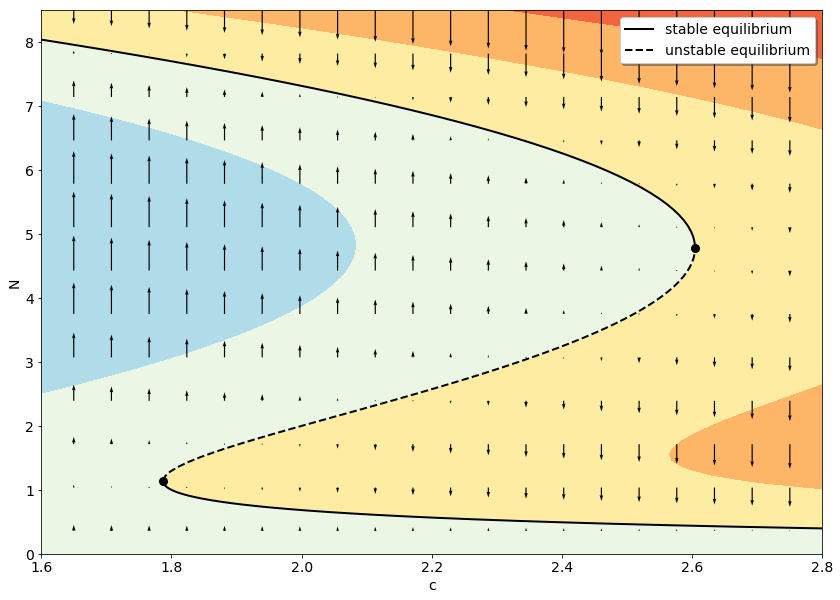

In [20]:
fig = plt.subplot(111)

# add contour plot
N_cntr = np.linspace(-1, 10, 100)
c_cntr = np.linspace(1.6, 2.8, 100)
dN_cntr = dNdt(N_cntr[:,None], 0, c_cntr[None,:], r, K, H)
fig.contourf(c_cntr, N_cntr, dN_cntr, levels=np.linspace(-2, 2, 9), cmap='RdYlBu')

# emphasize the 0-contour and tipping points
N1 = np.linspace(0.01, N_tipping[1], 50)
N2 = np.linspace(N_tipping[1], N_tipping[2], 50)
N3 = np.linspace(N_tipping[2], 9.0, 50)
fig.plot(cn(N1, r, H, K), N1, linewidth=2, c='k', label='stable equilibrium')
fig.plot(cn(N2, r, H, K), N2, linewidth=2, c='k', ls='dashed', label='unstable equilibrium')
fig.plot(cn(N3, r, H, K), N3, linewidth=2, c='k')
fig.plot(cn(N_tipping, r, H, K), N_tipping, 'o', ms=8, c='k')

# add quivers
quiver_mesh = np.meshgrid(
    np.linspace(1.65, 2.75, 20),
    np.linspace(-1, 8.5, 15))
N_q = quiver_mesh[1]
c_q = quiver_mesh[0]
quiver_dN = dNdt(N_q, 0, c_q, r, K, H)
fig.quiver(c_q, N_q, 0, quiver_dN, width=0.0015, scale=20)

# decoration
fig.set_xlabel('c')
fig.set_ylabel('N')
fig.set_ylim(0, 8.5)
fig.set_xlim(1.6, 2.8)
fig.legend(loc='upper right', shadow=True)

plt.savefig('catastrophe_diagram.pdf')
plt.show()

## Drawing random numbers

We'll need random numbers to do our stochastic integration. Luckily, the ``numpy`` package has a submodule called [``numpy.random``](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html). It gives us many different distributions to play around with. In our case we will only use the normal distribution. Here's an example use of the function ``numpy.random.normal``.

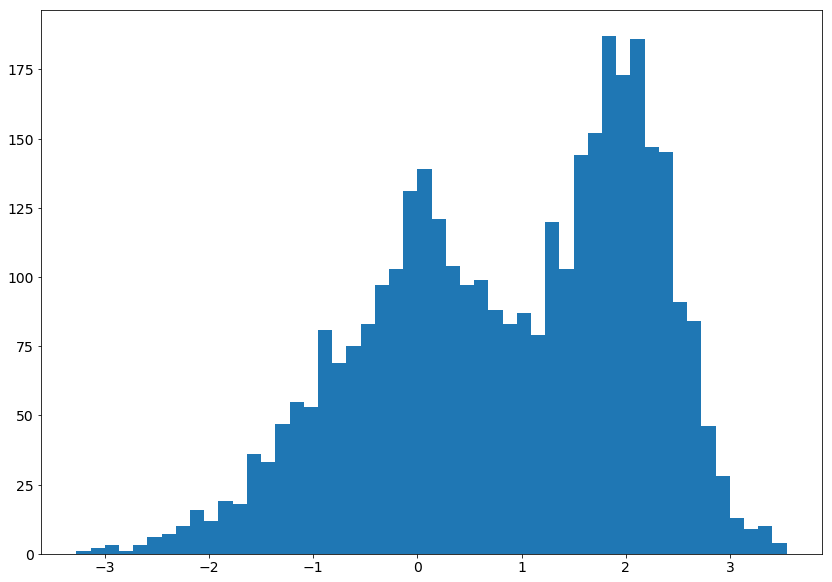

In [21]:
# draw numbers from two gaussian distributions
# and concatenate into single array.
numbers = np.concatenate([
    np.random.normal(0.0, 1.0, 2000),
    np.random.normal(2.0, 0.5, 1500)])

plt.hist(numbers, bins=50)
plt.show()

## Writing the Euler–Maruyama integrator

Solving differential equations is easy enough with ``scipy``. However, it does not have routines to integrate stochastic equations. There is a module called [``sdeint``](https://github.com/mattja/sdeint/) that does what we want. For the moment we will write our own integrator, since it is quite illustrative to do so.

An example implementation of the Euler-Maruyama integrator can be found on [Wikipedia](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method). Our implementation is slightly different. We're integrating many simulations in one go, leaving ``numpy`` to do the hard work for us. Also an option is included to keep results positive if needed.

In [22]:
def euler_maruyama(df, dt, x0, sigma, args, n, force_positive=True):
    """Integrate a stochastic differential equation.
    
    :param df: Function that gives dx/dt as function of x and t, non-stochastic part.
    :param dt: time-step.
    :param x0: initial values, should be array.
    :param sigma: scale factor function sigma(x, t) for stochastic term.
    :param args: extra keyword arguments for `df`.
    :param n: number of steps to integrate.
    :return: 2d array with time-series for each given initial value.
    """
    m = x0.size                  # number of simulations
    x = np.zeros(shape=(n, m))   # storage for results
    x[0] = x0                    # assign result for t=0
    t = np.arange(n) * dt        # define time values

    def dW():
        return np.random.normal(loc=0.0, scale=np.sqrt(dt), size=m)
    
    for i in range(0, n-1):
        x[i+1] = x[i] + dt * df(x[i], t[i], **args) + sigma(x[i], t[i]) * dW()
        if force_positive:
            x[i+1] = np.where(x[i+1] < 0, 0.0, x[i+1])
    
    return t, x

This function uses quite a few 'tricks' in Python that need explaining. For one, this function accepts other functions as arguments. We enter the realm of *higher order functions*. Some of these concepts may take some time to get used to.

> ### Note: functions as arguments
> Our definition of `euler_maruyama` has two arguments (`df` and `sigma`) that are expected to be functions. Functions are values as much as any other object in Python.

We have written the stochastic term ${\rm d}W$ as a function inside a function. The reason that we did this is that the most important line in the implementation,
```python
x[i+1] = x[i] + dt * df(x[i], t[i], **args) + sigma(x[i], t[i]) * dW()
```
now reflects the mathematical description of the Euler-Maruyama integrator,

$$x_{i+1} = x_i + f'(x_i, t_i)\ \Delta{}t + \sigma(x_i, t_i)\ \Delta{}W_i.$$

This makes the code more readable, which is a *good thing*.

> ### Note: nested functions
> In our implementation of the Euler-Maruyama algorithm we see that it is possible to define functions within the body of other functions! The inner function is aware of the variables that were defined in the outer function's *scope*.
>
> The inner function is only accessible from inside the outer function in which it is defined. However, it is possible for an outer function to return an inner nested function as a value. Remember: functions are values too!
>
> The following example will give an answer:
> ```python
> def multiply_by(x):
>    def multiply(y):
>        return x*y
>    
>    return multiply
>
> f = multiply_by(6)
> f(7)
> ```

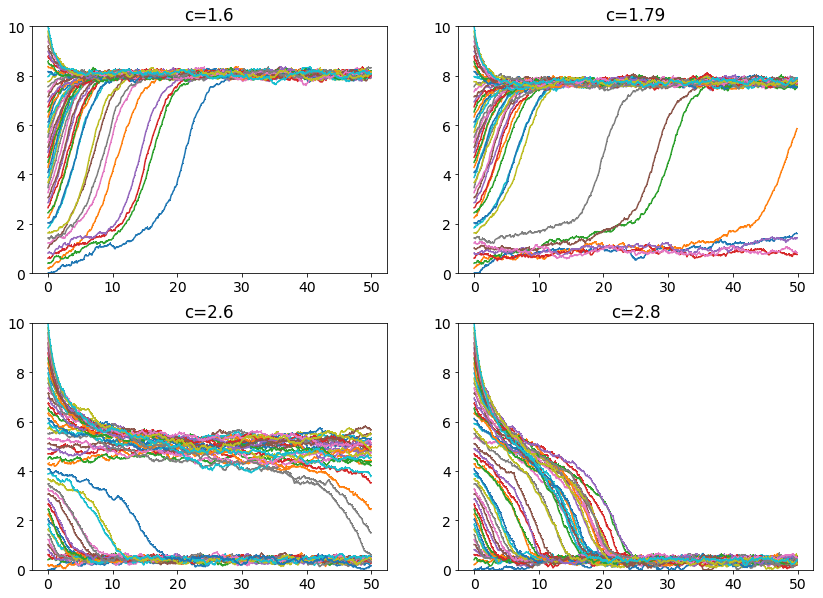

In [30]:
sigma_const = 0.1
sigma = lambda x, t: sigma_const
m = 50
x0 = np.linspace(0, 10, m)


for idx, c in enumerate([1.6, 1.787, 2.604, 2.8]):
    settings.update(c=c)
    t, x = euler_maruyama(
        df=dNdt, dt=0.1, x0=x0, sigma=sigma, args=settings, n=500)
    
    fig = plt.subplot(220 + idx + 1)
    fig.set_ylim(0.0, 10)
    fig.plot(np.repeat(t[:,None], m, axis=1), x, marker=',')
    fig.set_title('c={:.03}'.format(c))

plt.show()

## Integrate with variable $c(t)$

Now we change the equation slightly so that we can vary the parameter $c$ over time.

In [24]:
def dNdt_varc(N, t, c, r, K, H):
    return r*N * (1 - N/K) - c(t) * N**2 / (H**2 + N**2)

We create a function ``variable_c`` that interpolates between two chosen values.

> ### Recap & exercise: vectorized functions
> We'd like to define a piecewise function like this:
> ```python
> def variable_c(t):
>     a = 2.0
>     b = 2.8
>     t1 = 20
>     t2 = 50
>
>     if t < t1:
>         return a
>     elif t > t2:
>         return b
>     else:
>         return a + (b - a) * (t - t1) / (t2 - t1)
> ```
> **Problem 1:** This function could be generalized so that we can use it for other values of `a`, `b`, `t1` and `t2`. Write a function `interpolate_values(t1, a, t2, b)` that returns a new function with the correct behaviour.
>
> **Problem 2:** This particular implementation is not vectorized. We can use `numpy.where` in stead of `if`-statements to make this function faster. Plot your results.

In [25]:
# Solution, delete before sharing =========================================
def interpolate_values(t1, a, t2, b):
    def f(t):
        interpolated = a + (b - a) * (t - t1) / (t2 - t1)
        return np.where(
            t < t1, a,
            np.where(t > t2, b, interpolated))
    
    return f

variable_c = interpolate_values(0, 3.0, 100, 0.5)
# Solution, delete before sharing =========================================

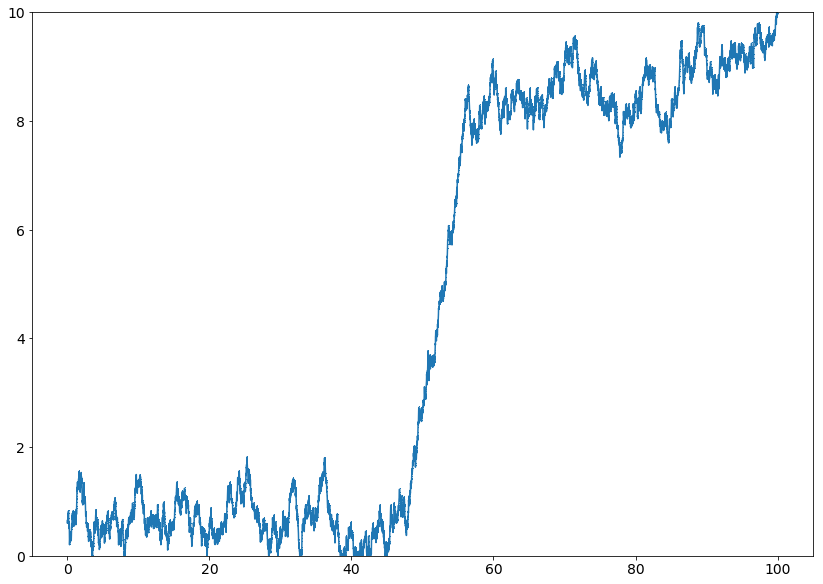

In [32]:
sigma_const = 0.5
m = 1
x0 = np.random.normal(loc=0.5, scale=0.1, size=m)
settings.update(c=variable_c)

t, x = euler_maruyama(
    df=dNdt_varc, dt=0.01, x0=x0, sigma=sigma, args=settings, n=10000)

fig = plt.subplot(111)
fig.set_ylim(0.0, 10)
fig.plot(np.repeat(t[:,None], m, axis=1), x, marker=',')
plt.show()

> ### Exercise: use the `sdeint` module
> We have now used our own Euler-Maruyama integrator to solve the SDE. There exist better algorithms that can handle more complicated models and better performance. The `sdeint` module already has these algorithms, so we don't have to implement them!
>
> **Problem 3:** Run our SDE using `sdeint.itoint`
>
> **hint:** `sdeint` integrators don't support passing additional arguments to the functions. You may need to define a helper function, or if you feel adventurous, use `lambda`.

In [36]:
import sdeint

help(sdeint.itoint)

Help on function itoint in module sdeint.integrate:

itoint(f, G, y0, tspan)
    Numerically integrate Ito equation  dy = f dt + G dW



In [ ]:
# Solution, delete before sharing =========================================
import sdeint


# Solution, delete before sharing =========================================

# Time series analysis
Next, we'll do some analysis on the generated time serie(s) using available functions in `scipy`.